<a href="https://colab.research.google.com/github/visheshrao17/CIFAR-Experimentation-/blob/main/CNN_CIAFR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

# Define transformations for the dataset
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

print("Libraries imported and transformations defined.")

Libraries imported and transformations defined.


In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


train_subset_size = 5000
test_subset_size = 1000

# Create a subset of the training dataset
train_indices = torch.randperm(len(trainset))[:train_subset_size]
train_subset = Subset(trainset, train_indices)

# Create a subset of the test dataset
test_indices = torch.randperm(len(testset))[:test_subset_size]
test_subset = Subset(testset, test_indices)

# Define batch size
batch_size = 64

# Create DataLoader instances
trainloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

print(f"CIFAR-10 training dataset loaded with {len(train_subset)} samples.")
print(f"CIFAR-10 test dataset loaded with {len(test_subset)} samples.")
print(f"DataLoader instances created with batch size {batch_size}.")

100%|██████████| 170M/170M [00:36<00:00, 4.68MB/s] 


CIFAR-10 training dataset loaded with 5000 samples.
CIFAR-10 test dataset loaded with 1000 samples.
DataLoader instances created with batch size 64.


In [4]:
import torch.nn as nn
import torch.nn.functional as F

# Define a Convolutional Neural Network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.pool = nn.MaxPool2d(2, 2) 
        self.conv2 = nn.Conv2d(6, 16, 5) 
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

print("CNN model architecture defined.")

CNN model architecture defined.


In [5]:
import torch.optim as optim

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()  
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  

        outputs = model(inputs) 
        loss = criterion(outputs, labels) 
        loss.backward()  
        optimizer.step() 

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total_samples
    epoch_accuracy = correct_predictions / total_samples
    return epoch_loss, epoch_accuracy

def validate_epoch(model, dataloader, criterion, device):
    model.eval()  
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_accuracy = correct_predictions / total_samples
    return epoch_loss, epoch_accuracy

print("Training and validation functions defined.")

Training and validation functions defined.


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define hyperparameters to experiment with
learning_rates = [0.01, 0.001]
batch_sizes = [32, 64]
num_epochs_list = [5, 10]

best_val_accuracy = 0.0
best_hyperparameters = {}

results = []

for lr in learning_rates:
    for bs in batch_sizes:
        for epochs in num_epochs_list:
            print(f"\n--- Experimenting with LR: {lr}, Batch Size: {bs}, Epochs: {epochs} ---")

            # Re-initialize model and optimizer for each experiment
            model = Net().to(device)
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

            # Create new DataLoader instances with current batch size
            trainloader_exp = DataLoader(train_subset, batch_size=bs, shuffle=True)
            testloader_exp = DataLoader(test_subset, batch_size=bs, shuffle=False)

            # Lists to store metrics for the current hyperparameter combination
            current_train_losses = []
            current_train_accuracies = []
            current_val_losses = []
            current_val_accuracies = []
            
            for epoch in range(epochs):
                # Train the model for one epoch
                train_loss, train_acc = train_epoch(model, trainloader_exp, criterion, optimizer, device)
                current_train_losses.append(train_loss)
                current_train_accuracies.append(train_acc)

                # Validate the model
                val_loss, val_acc = validate_epoch(model, testloader_exp, criterion, device)
                current_val_losses.append(val_loss)
                current_val_accuracies.append(val_acc)

                print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
            
            # Store results for this combination
            results.append({
                'learning_rate': lr,
                'batch_size': bs,
                'num_epochs': epochs,
                'train_losses': current_train_losses,
                'train_accuracies': current_train_accuracies,
                'val_losses': current_val_losses,
                'val_accuracies': current_val_accuracies
            })

            # Check if this model is the best performing one
            if current_val_accuracies[-1] > best_val_accuracy:
                best_val_accuracy = current_val_accuracies[-1]
                best_hyperparameters = {
                    'learning_rate': lr,
                    'batch_size': bs,
                    'num_epochs': epochs
                }
                # Optionally, save the best model state here
                # torch.save(model.state_dict(), 'best_model.pth')

print(f"\nBest Validation Accuracy: {best_val_accuracy:.4f} with Hyperparameters: {best_hyperparameters}")

Using device: cpu

--- Experimenting with LR: 0.01, Batch Size: 32, Epochs: 5 ---
Epoch 1/5 | Train Loss: 2.2510, Train Acc: 0.1502 | Val Loss: 2.0745, Val Acc: 0.2090
Epoch 2/5 | Train Loss: 2.0030, Train Acc: 0.2434 | Val Loss: 1.8768, Val Acc: 0.3080
Epoch 3/5 | Train Loss: 1.8037, Train Acc: 0.3388 | Val Loss: 1.7442, Val Acc: 0.3360
Epoch 4/5 | Train Loss: 1.6796, Train Acc: 0.3754 | Val Loss: 1.7101, Val Acc: 0.3630
Epoch 5/5 | Train Loss: 1.5959, Train Acc: 0.4130 | Val Loss: 1.6061, Val Acc: 0.4110

--- Experimenting with LR: 0.01, Batch Size: 32, Epochs: 10 ---
Epoch 1/10 | Train Loss: 2.2999, Train Acc: 0.1078 | Val Loss: 2.2898, Val Acc: 0.1610
Epoch 2/10 | Train Loss: 2.1179, Train Acc: 0.2306 | Val Loss: 1.9607, Val Acc: 0.2840
Epoch 3/10 | Train Loss: 1.8868, Train Acc: 0.2910 | Val Loss: 1.8307, Val Acc: 0.3200
Epoch 4/10 | Train Loss: 1.7265, Train Acc: 0.3662 | Val Loss: 1.7609, Val Acc: 0.3270
Epoch 5/10 | Train Loss: 1.6276, Train Acc: 0.3968 | Val Loss: 1.6757, Val 

**Data Augmentation**

In [7]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

# 1. Define a new set of transformations for the training dataset with augmentation
train_transform = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

# 2. Define a separate set of transformations for the test dataset without augmentation
test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

print("Data augmentation transformations defined for training and testing datasets.")

Data augmentation transformations defined for training and testing datasets.


In [8]:
import torchvision
from torch.utils.data import DataLoader, Subset


trainset_augmented = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
testset_augmented = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

train_subset_augmented = Subset(trainset_augmented, train_indices)
test_subset_augmented = Subset(testset_augmented, test_indices)


batch_size_augmented = best_hyperparameters.get('batch_size', 64) 

trainloader_augmented = DataLoader(train_subset_augmented, batch_size=batch_size_augmented, shuffle=True)
testloader_augmented = DataLoader(test_subset_augmented, batch_size=batch_size_augmented, shuffle=False)

print(f"Augmented CIFAR-10 training dataset loaded with {len(train_subset_augmented)} samples.")
print(f"Augmented CIFAR-10 test dataset loaded with {len(test_subset_augmented)} samples.")
print(f"DataLoader instances created with augmented data and batch size {batch_size_augmented}.")


Augmented CIFAR-10 training dataset loaded with 5000 samples.
Augmented CIFAR-10 test dataset loaded with 1000 samples.
DataLoader instances created with augmented data and batch size 32.


In [9]:
print("\n--- Retraining model with best hyperparameters and augmented data ---")

# Initialize a new Net model and move it to the device
model_augmented = Net().to(device)

# Initialize optimizer with learning rate from best_hyperparameters
lr_augmented = best_hyperparameters['learning_rate']
optimizer_augmented = optim.SGD(model_augmented.parameters(), lr=lr_augmented, momentum=0.9)

# Initialize the criterion
criterion_augmented = nn.CrossEntropyLoss()

# Get number of epochs from best_hyperparameters
num_epochs_augmented = best_hyperparameters['num_epochs']

# Lists to store metrics for the augmented model training
augmented_train_losses = []
augmented_train_accuracies = []
augmented_val_losses = []
augmented_val_accuracies = []

for epoch in range(num_epochs_augmented):
    # Train the model for one epoch
    train_loss_aug, train_acc_aug = train_epoch(model_augmented, trainloader_augmented, criterion_augmented, optimizer_augmented, device)
    augmented_train_losses.append(train_loss_aug)
    augmented_train_accuracies.append(train_acc_aug)

    # Validate the model
    val_loss_aug, val_acc_aug = validate_epoch(model_augmented, testloader_augmented, criterion_augmented, device)
    augmented_val_losses.append(val_loss_aug)
    augmented_val_accuracies.append(val_acc_aug)

    print(f"Epoch {epoch+1}/{num_epochs_augmented} | Train Loss: {train_loss_aug:.4f}, Train Acc: {train_acc_aug:.4f} | Val Loss: {val_loss_aug:.4f}, Val Acc: {val_acc_aug:.4f}")

# Evaluate the final model performance on the testloader_augmented
final_val_loss_augmented, final_val_acc_augmented = validate_epoch(model_augmented, testloader_augmented, criterion_augmented, device)
print(f"\nFinal Validation Loss with augmented data: {final_val_loss_augmented:.4f}")
print(f"Final Validation Accuracy with augmented data: {final_val_acc_augmented:.4f}")


--- Retraining model with best hyperparameters and augmented data ---
Epoch 1/10 | Train Loss: 2.2891, Train Acc: 0.1206 | Val Loss: 2.2226, Val Acc: 0.1930
Epoch 2/10 | Train Loss: 2.0668, Train Acc: 0.2298 | Val Loss: 1.9673, Val Acc: 0.2740
Epoch 3/10 | Train Loss: 1.9216, Train Acc: 0.2876 | Val Loss: 1.8403, Val Acc: 0.3190
Epoch 4/10 | Train Loss: 1.8328, Train Acc: 0.3200 | Val Loss: 1.6804, Val Acc: 0.3750
Epoch 5/10 | Train Loss: 1.7653, Train Acc: 0.3492 | Val Loss: 1.6727, Val Acc: 0.3610
Epoch 6/10 | Train Loss: 1.7265, Train Acc: 0.3534 | Val Loss: 1.6484, Val Acc: 0.3960
Epoch 7/10 | Train Loss: 1.6956, Train Acc: 0.3664 | Val Loss: 1.5816, Val Acc: 0.4180
Epoch 8/10 | Train Loss: 1.6493, Train Acc: 0.3992 | Val Loss: 1.5739, Val Acc: 0.4210
Epoch 9/10 | Train Loss: 1.6125, Train Acc: 0.4150 | Val Loss: 1.5295, Val Acc: 0.4540
Epoch 10/10 | Train Loss: 1.5912, Train Acc: 0.4162 | Val Loss: 1.6188, Val Acc: 0.4280

Final Validation Loss with augmented data: 1.6188
Final V

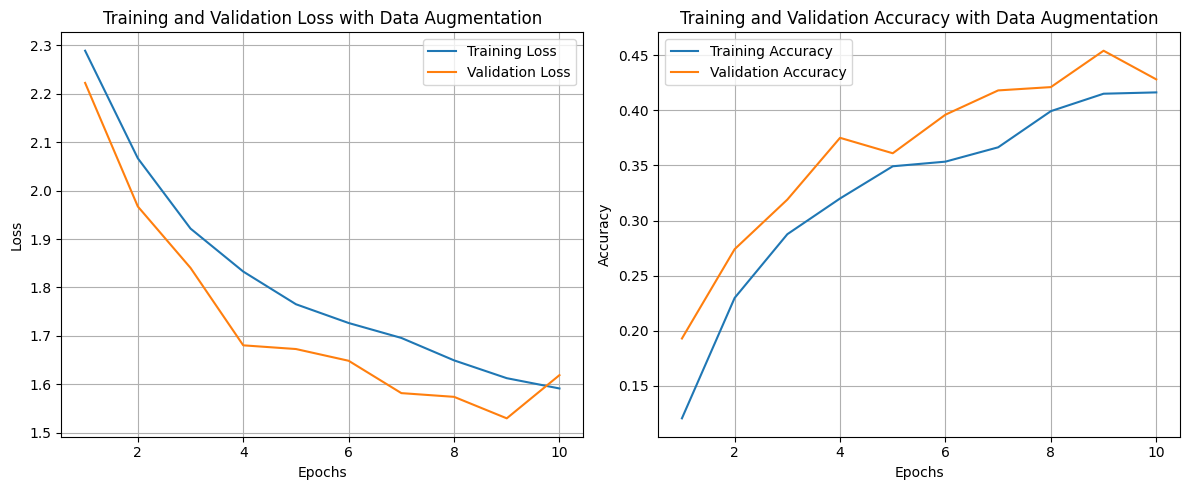

Training and validation curves plotted.


In [10]:
import matplotlib.pyplot as plt

epochs_range = range(1, num_epochs_augmented + 1)

# Plotting Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, augmented_train_losses, label='Training Loss')
plt.plot(epochs_range, augmented_val_losses, label='Validation Loss')
plt.title('Training and Validation Loss with Data Augmentation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, augmented_train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, augmented_val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy with Data Augmentation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("Training and validation curves plotted.")

In [12]:
import pandas as pd


summary_data = []


for res in results:
    summary_data.append({
        'Experiment Type': 'Without Augmentation',
        'Learning Rate': res['learning_rate'],
        'Batch Size': res['batch_size'],
        'Num Epochs': res['num_epochs'],
        'Final Val Accuracy': res['val_accuracies'][-1]
    })


summary_data.append({
    'Experiment Type': 'With Augmentation',
    'Learning Rate': best_hyperparameters['learning_rate'],
    'Batch Size': best_hyperparameters['batch_size'],
    'Num Epochs': best_hyperparameters['num_epochs'],
    'Final Val Accuracy': final_val_acc_augmented
})


summary_df = pd.DataFrame(summary_data)

print("\n--- Summary of Experimental Results ---")
display(summary_df.round(4))

print(f"\nBest Validation Accuracy (without augmentation): {best_val_accuracy:.4f}")
print(f"Final Validation Accuracy (with augmentation, best hyperparameters): {final_val_acc_augmented:.4f}")


--- Summary of Experimental Results ---


,Experiment Type,Learning Rate,Batch Size,Num Epochs,Final Val Accuracy
0,Without Augmentation,0.010,32,5,0.411
1,Without Augmentation,0.010,32,10,0.443
2,Without Augmentation,0.010,64,5,0.396
3,Without Augmentation,0.010,64,10,0.434
4,Without Augmentation,0.001,32,5,0.157
5,Without Augmentation,0.001,32,10,0.263
6,Without Augmentation,0.001,64,5,0.137
7,Without Augmentation,0.001,64,10,0.161
8,With Augmentation,0.010,32,10,0.428



Best Validation Accuracy (without augmentation): 0.4430
Final Validation Accuracy (with augmentation, best hyperparameters): 0.4280
